# Descriptive Visualizations

The purpose of this notebook is to visually examine the nominal features, discard the useless ones among them, and create new factor variables.

The "main" plot used in this notebook is *Gr Liv Area* vs. *SalePrice* as the overall living area is the most correlated predictor (which is also very intuitive). Many of the nominal variables change the slopes of the regression lines for sub-groups of data points significantly.

## "Housekeeping"

In [1]:
% load_ext watermark
% watermark -d -t -v -z -p matplotlib,numpy,pandas,seaborn

2018-09-05 00:46:53 CEST

CPython 3.6.5
IPython 6.5.0

matplotlib 3.0.0rc2
numpy 1.15.1
pandas 0.23.4
seaborn 0.9.0


In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import IsolationForest

from utils import (
    ALL_COLUMNS,
    NOMINAL_VARIABLES,
    TARGET_VARIABLES,
    load_clean_data,
    encode_ordinals,
    print_column_list,
)

In [3]:
% matplotlib inline

In [4]:
random_state = np.random.RandomState(42)

In [5]:
pd.set_option("display.max_columns", 120)

In [6]:
sns.set_style("white")

## Load the Data


In [7]:
df = load_clean_data(path="data/data_clean_with_transformations.csv")

In [8]:
df.shape

(2898, 81)

In [9]:
df.head()

,,1st Flr SF,2nd Flr SF,3Ssn Porch,Alley,Bedroom AbvGr,Bldg Type,Bsmt Cond,Bsmt Exposure,Bsmt Full Bath,Bsmt Half Bath,Bsmt Qual,Bsmt Unf SF,BsmtFin SF 1,BsmtFin SF 2,BsmtFin Type 1,BsmtFin Type 2,Central Air,Condition 1,Condition 2,Electrical,Enclosed Porch,Exter Cond,Exter Qual,Exterior 1st,Exterior 2nd,Fence,Fireplace Qu,Fireplaces,Foundation,Full Bath,Functional,Garage Area,Garage Cars,Garage Cond,Garage Finish,Garage Qual,Garage Type,Gr Liv Area,Half Bath,Heating,Heating QC,House Style,Kitchen AbvGr,Kitchen Qual,Land Contour,Land Slope,Lot Area,Lot Config,Lot Shape,Low Qual Fin SF,MS SubClass,MS Zoning,Mas Vnr Area,Mas Vnr Type,Misc Feature,Misc Val,Mo Sold,Neighborhood,Open Porch SF,Overall Cond,Overall Qual,Paved Drive,Pool Area,Pool QC,Roof Matl,Roof Style,Sale Condition,Sale Type,Screen Porch,Street,TotRms AbvGrd,Total Bath,Total Bsmt SF,Total Porch SF,Utilities,Wood Deck SF,Year Built,Year Remod/Add,Yr Sold,SalePrice,SalePrice (box-cox-0.0)
Order,PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,1656.0,0.0,0.0,NA,3,1Fam,Gd,Gd,1,0,TA,441.0,639.0,0.0,BLQ,Unf,Y,Norm,Norm,SBrkr,0.0,TA,TA,BrkFace,Plywood,NA,Gd,2,CBlock,1,Typ,528.0,2,TA,Fin,TA,Attchd,1656.0,0,GasA,Fa,1Story,1,TA,Lvl,Gtl,31770.0,Corner,IR1,0.0,020,RL,112.0,Stone,NA,0.0,5,Names,62.0,5,6,P,0.0,NA,CompShg,Hip,Normal,WD,0.0,Pave,7,2.0,1080.0,272.0,AllPub,210.0,1960,1960,2010,215000.0,12.278393
2,526350040,896.0,0.0,0.0,NA,2,1Fam,TA,No,0,0,TA,270.0,468.0,144.0,Rec,LwQ,Y,Feedr,Norm,SBrkr,0.0,TA,TA,VinylSd,VinylSd,MnPrv,NA,0,CBlock,1,Typ,730.0,1,TA,Unf,TA,Attchd,896.0,0,GasA,TA,1Story,1,TA,Lvl,Gtl,11622.0,Inside,Reg,0.0,020,RH,0.0,None,NA,0.0,6,Names,0.0,6,5,Y,0.0,NA,CompShg,Gable,Normal,WD,120.0,Pave,5,1.0,882.0,260.0,AllPub,140.0,1961,1961,2010,105000.0,11.561716
3,526351010,1329.0,0.0,0.0,NA,3,1Fam,TA,No,0,0,TA,406.0,923.0,0.0,ALQ,Unf,Y,Norm,Norm,SBrkr,0.0,TA,TA,Wd Sdng,Wd Sdng,NA,NA,0,CBlock,1,Typ,312.0,1,TA,Unf,TA,Attchd,1329.0,1,GasA,TA,1Story,1,Gd,Lvl,Gtl,14267.0,Corner,IR1,0.0,020,RL,108.0,BrkFace,Gar2,12500.0,6,Names,36.0,6,6,Y,0.0,NA,CompShg,Hip,Normal,WD,0.0,Pave,6,1.5,1329.0,429.0,AllPub,393.0,1958,1958,2010,172000.0,12.055250
4,526353030,2110.0,0.0,0.0,NA,3,1Fam,TA,No,1,0,TA,1045.0,1065.0,0.0,ALQ,Unf,Y,Norm,Norm,SBrkr,0.0,TA,Gd,BrkFace,BrkFace,NA,TA,2,CBlock,2,Typ,522.0,2,TA,Fin,TA,Attchd,2110.0,1,GasA,Ex,1Story,1,Ex,Lvl,Gtl,11160.0,Corner,Reg,0.0,020,RL,0.0,None,NA,0.0,4,Names,0.0,5,7,Y,0.0,NA,CompShg,Hip,Normal,WD,0.0,Pave,8,3.5,2110.0,0.0,AllPub,0.0,1968,1968,2010,244000.0,12.404924
5,527105010,928.0,701.0,0.0,NA,3,1Fam,TA,No,0,0,Gd,137.0,791.0,0.0,GLQ,Unf,Y,Norm,Norm,SBrkr,0.0,TA,TA,VinylSd,VinylSd,MnPrv,TA,1,PConc,2,Typ,482.0,2,TA,Fin,TA,Attchd,1629.0,1,GasA,Gd,2Story,1,TA,Lvl,Gtl,13830.0,Inside,IR1,0.0,060,RL,0.0,None,NA,0.0,3,Gilbert,34.0,5,5,Y,0.0,NA,CompShg,Gable,Normal,WD,0.0,Pave,6,2.5,928.0,246.0,AllPub,212.0,1997,1998,2010,189900.0,12.154253


Newly created variables are collected in the *new_variables* list.

In [10]:
new_variables = []

Throughout this notebook predictors that have "interesting" visual patterns are collected in the *interesting_variables* list. Together with the previously identified predictors weakly and strongly correlated with the price, a naive feature selection will be done in the next notebooks.

In [11]:
interesting_variables = []

## Derived Characteristics

Certain characteristics of a house are assumed to have a "binary" influence on the sales price. For example, the existence of a pool could be an important predictor while the exact size of the pool can be deemed not so important.

The below cell creates boolean factor variables out of a set of numeric variables.

In [12]:
derived_variables = {
    "has 2nd Flr": "2nd Flr SF",
    "has Bsmt": "Total Bsmt SF",
    "has Fireplace": "Fireplaces",
    "has Garage": "Garage Area",
    "has Pool": "Pool Area",
    "has Porch": "Total Porch SF",
}
# Factorize numeric columns.
for factor_column, column in derived_variables.items():
    df[factor_column] = df[column].apply(lambda x: 1 if x > 0 else 0)
derived_variables = list(derived_variables.keys())

In [13]:
new_variables.extend(derived_variables)

In [14]:
df[derived_variables].head()

,,has 2nd Flr,has Bsmt,has Fireplace,has Garage,has Pool,has Porch
Order,PID,,,,,,
1,526301100,0,1,1,1,0,1
2,526350040,0,1,0,1,0,1
3,526351010,0,1,0,1,0,1
4,526353030,0,1,1,1,0,0
5,527105010,1,1,1,1,0,1


### 2nd Floors

A second floor clearly has a positive effect on the sales price. However, having a second floor correlates with overall living space. The individual effect is therefore not as clear as it seems in the plot below.

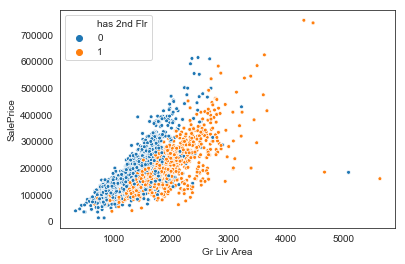

In [15]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="has 2nd Flr", s=15, data=df);

In [16]:
interesting_variables.append("has 2nd Flr")

### Basements

Nearly all houses in Ames, IA, have a basement. Therefore, *has Bsmt* is most likely not an important predictor.

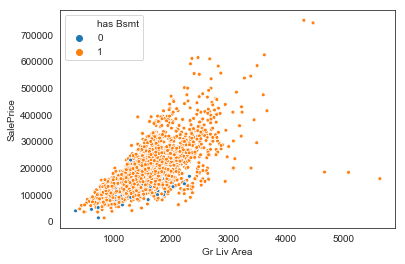

In [17]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="has Bsmt", s=15, data=df);

### Fireplaces

Bigger houses are more likely to have a fireplace. Thus, the variable *has Fireplace* might be an interesting predictor.

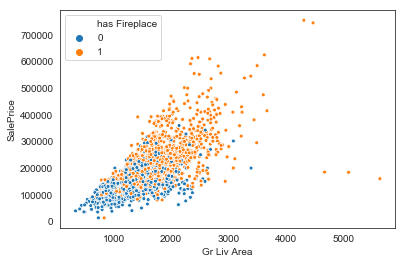

In [18]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="has Fireplace", s=15, data=df);

In [19]:
interesting_variables.append("has Fireplace")

### Garages

Holding the overall living area fixed adding a garage seems to affect the price positively. Thus, *has Garage* seems like an interesting predictor as well.

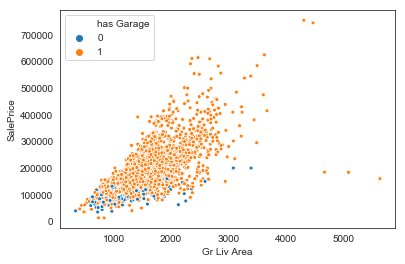

In [20]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="has Garage", s=15, data=df);

In [21]:
interesting_variables.append("has Garage")

### Pools

Unfortunately, almost no one in Ames, IA, has a pool. The predictor *has Pool* seems quite uninteresting.

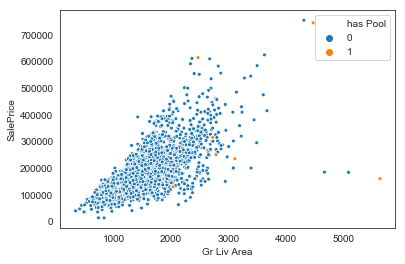

In [22]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="has Pool", s=15, data=df);

### Porch

Most houses have a porch.

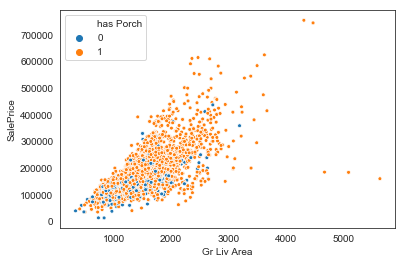

In [23]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="has Porch", s=15, data=df);

## Neighborhoods

The instructors' notes say:

> For instructors who cover nominal variables in their class, I would suggest incorporating the neighborhood variable into their models by converting it to a set of dummy (indicator) variables. I have found that the coefficients for the continuous variables tend to have values with more realistic interpretations when used in conjunction with the neighborhood variable.

Indeed, plotting the price distributions by neighborhood reveals significant differences in the price level.

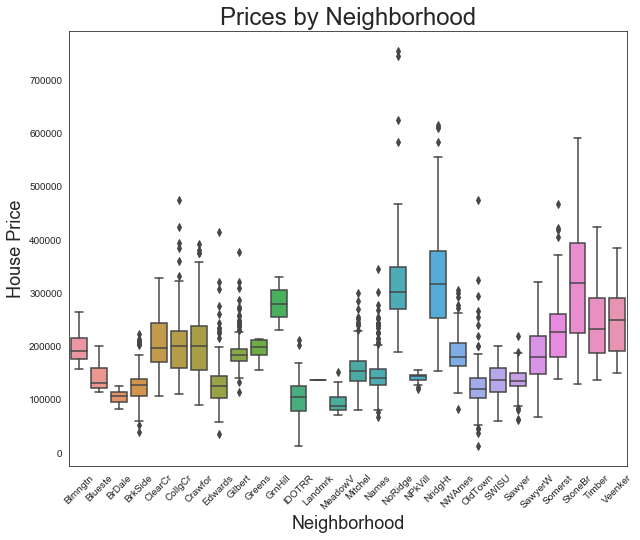

In [24]:
_, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x="Neighborhood", y="SalePrice", data=df, ax=ax)
ax.set_title("Prices by Neighborhood", fontsize=24)
ax.set_xlabel("Neighborhood", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("House Price", fontsize=18);

The 28 neighborhoods are encoded as factor variables.

In [25]:
neighborhood = pd.get_dummies(df["Neighborhood"], prefix="nhood")
df = pd.concat([df, neighborhood], axis=1)
del df["Neighborhood"]

In [26]:
new_variables.extend(neighborhood.columns)
interesting_variables.extend(neighborhood.columns)

In [27]:
df[neighborhood.columns].shape

(2898, 28)

In [28]:
df[neighborhood.columns].head()

,,nhood_Blmngtn,nhood_Blueste,nhood_BrDale,nhood_BrkSide,nhood_ClearCr,nhood_CollgCr,nhood_Crawfor,nhood_Edwards,nhood_Gilbert,nhood_Greens,nhood_GrnHill,nhood_IDOTRR,nhood_Landmrk,nhood_MeadowV,nhood_Mitchel,nhood_Names,nhood_NoRidge,nhood_NPkVill,nhood_NridgHt,nhood_NWAmes,nhood_OldTown,nhood_SWISU,nhood_Sawyer,nhood_SawyerW,nhood_Somerst,nhood_StoneBr,nhood_Timber,nhood_Veenker
Order,PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,526350040,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,526351010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,526353030,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,527105010,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Nominal Features

This section investigates the rest of the nominal variables with regard to which realizations / encoding might be a useful predictor.

In [29]:
print_column_list(set(NOMINAL_VARIABLES) - set(["Neighborhood"]))

Alley           Type of alley access to property
Bldg Type       Type of dwelling
Central Air     Central air conditioning
Condition 1     Proximity to various conditions
Condition 2     Proximity to various conditions (if more than one is present)
Exterior 1st    Exterior covering on house
Exterior 2nd    Exterior covering on house (if more than one material)
Foundation      Type of foundation
Garage Type     Garage location
Heating         Type of heating
House Style     Style of dwelling
Land Contour    Flatness of the property
Lot Config      Lot configuration
MS SubClass     Identifies the type of dwelling involved in the sale.
MS Zoning       Identifies the general zoning classification of the sale.
Mas Vnr Type    Masonry veneer type
Misc Feature    Miscellaneous feature not covered in other categories
Roof Matl       Roof material
Roof Style      Type of roof
Sale Condition  Condition of sale
Sale Type       Type of sale
Street          Type of road access to property


### Alleys

Almost no house has access to an alley.

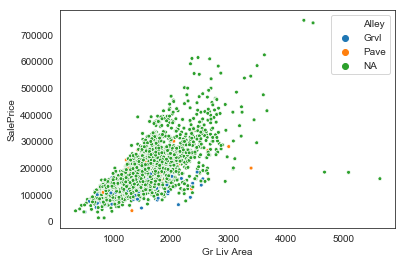

In [30]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Alley", s=15, data=df);

In [31]:
del df["Alley"]

### Building Type

The type of a building clearly affects the valuation. The two types of townhouses as well as the 2-family condo and duplex type are summarized into a single category. This makes sense a) semantically, and b) by looking at the two sub-clusters in the scatter plot.

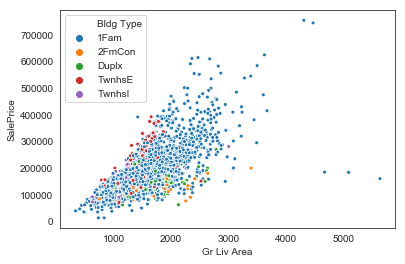

In [32]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Bldg Type", s=15, data=df);

In [33]:
# Unify the two townhouse types into one.
df["Bldg Type"] = df["Bldg Type"].apply(
    lambda x: "Twnhs" if x in ("TwnhsE", "TwnhsI") else x
)
# Unify the two kinds of 2-family homes.
df["Bldg Type"] = df["Bldg Type"].apply(
    lambda x: "2Fam" if x in ("2FmCon", "Duplx") else x
)

In [34]:
build_type = pd.get_dummies(df["Bldg Type"], prefix="build_type")
df = pd.concat([df, build_type], axis=1)
del df["Bldg Type"]

In [35]:
new_variables.extend(build_type.columns)
interesting_variables.extend(build_type.columns)

In [36]:
df[build_type.columns].head()

,,build_type_1Fam,build_type_2Fam,build_type_Twnhs
Order,PID,,,
1,526301100,1,0,0
2,526350040,1,0,0
3,526351010,1,0,0
4,526353030,1,0,0
5,527105010,1,0,0


### Air Conditioning

Air conditioning clearly increases the valuation ("steeper" regression line with respect to the overall living area).

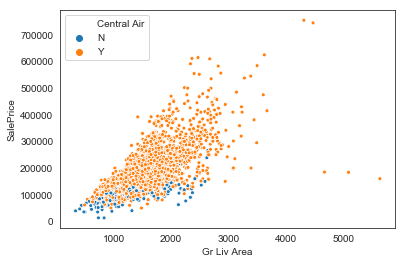

In [37]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Central Air", s=15, data=df);

Use a new variable name to cleary show that the variable's *dtype* is changed from *str* to *int*.

In [38]:
df["air_cond"] = df["Central Air"].apply(lambda x: 1 if x == "Y" else 0).astype(int)
del df["Central Air"]

In [39]:
new_variables.append("air_cond")
interesting_variables.append("air_cond")

In [40]:
df[["air_cond"]].head()

,,air_cond
Order,PID,
1,526301100,1
2,526350040,1
3,526351010,1
4,526353030,1
5,527105010,1


### "Proximity to various Conditions"

The columns *Condition 1* and *Condition 2* have the same realizations and can be regarded as "tags" given to a house indicating the nearby presence of a) a major street, b) a railroad, or c) a park.

The default tag "Norm" (implying no "condition") is given to 86% of the houses (this realization should therefore not be regarded as a tag!).

From the comparison of the grouped scatter plots below, it can be assumed that the proximity of a major street decreases the valuation (lower regression slope through the cloud of blue and orange dots). Therefore, a factor variable *major_street* is extracted indicating the proximity of an "artery" or "feeder" street.

Further, a factor variable *railway* is extracted as a relatively high proportion of the houses has such a tag. From the plots, a railway seems to not affect the valuations strongly.

Lastly, a factor variable *park* is extracted. From the plots, this does not seem to affect the valuation much.

List the "raw" realizations:

In [41]:
(df["Condition 1"].value_counts() + df["Condition 2"].value_counts()).sort_values(
    ascending=False
)[1:]

Feedr     174
Artery     97
RRAn       48
PosN       43
RRAe       29
PosA       24
RRNn       11
RRNe        6
dtype: int64

In [42]:
# Condition 2 is only filled with anything other than "Norm"
# if Condition 1 already has such a tag.
assert not ((df["Condition 1"] == "Norm") & (df["Condition 2"] != "Norm")).any()

In [43]:
# 86% of the houses actually have no tag.
round(100* (df["Condition 1"] == "Norm").sum() / df.shape[0])

86.0

From a simple scatter plot it is hard to see any significant impact by a predictor.

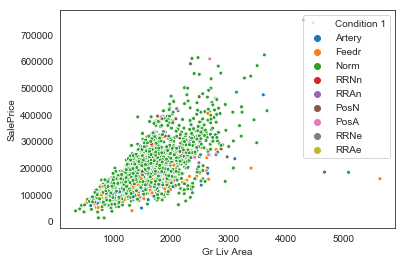

In [44]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Condition 1", s=15, data=df);

However, plotting the groups seperately reveals different slopes.

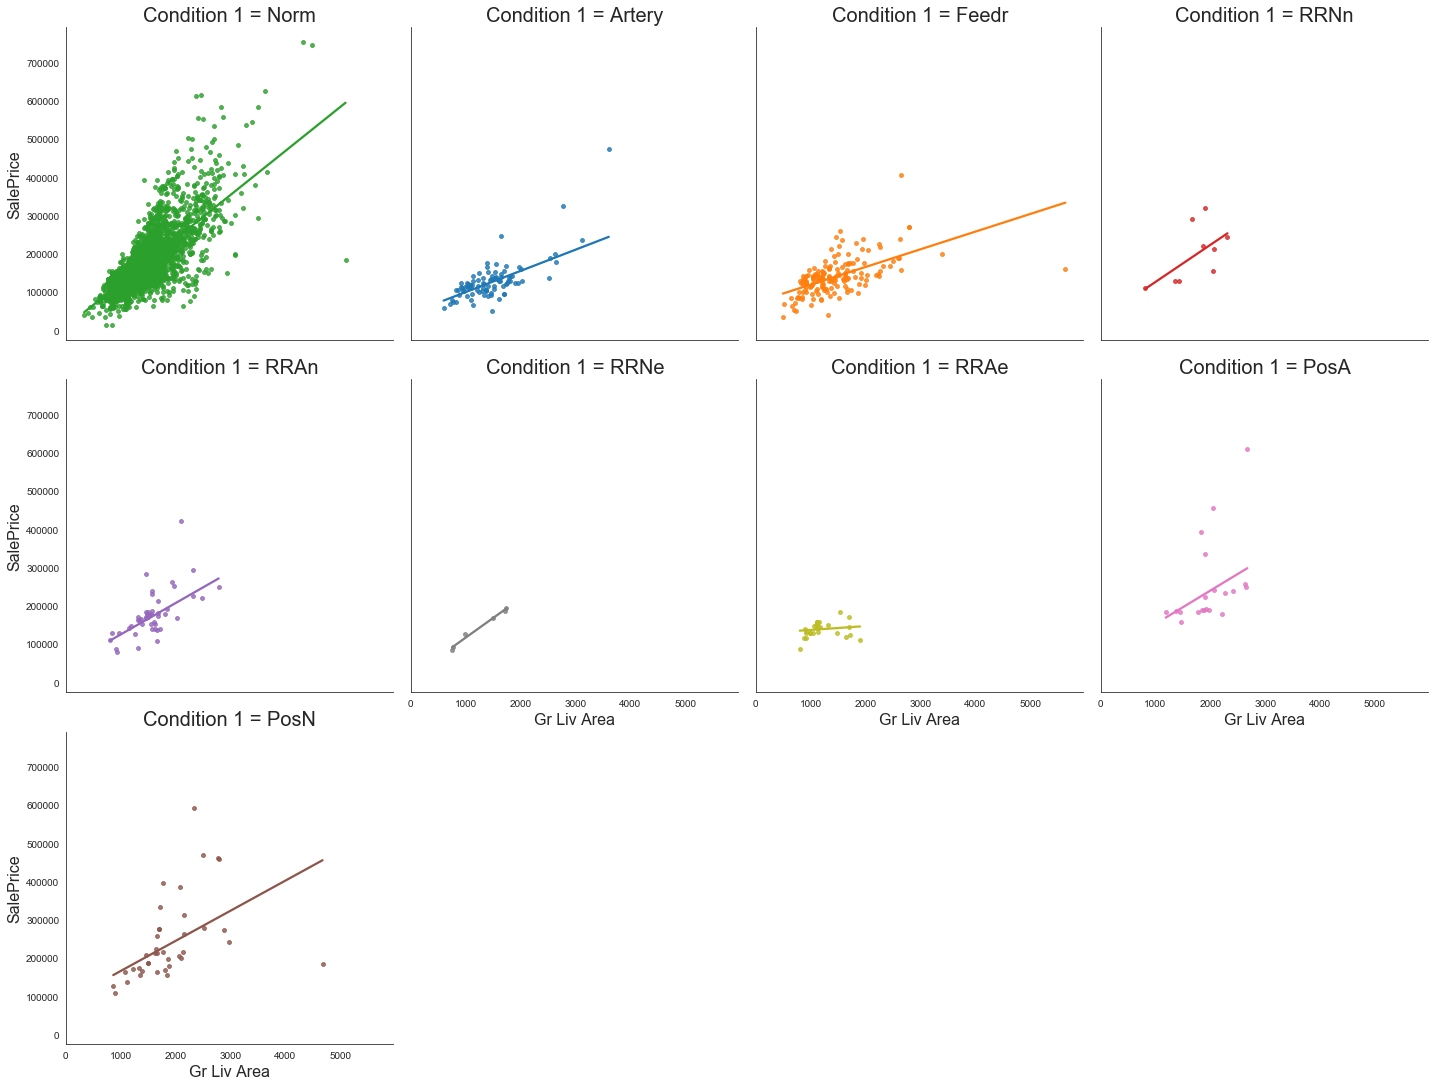

In [45]:
street = ["Artery", "Feedr"]
railway = ["RRNn", "RRAn", "RRNe", "RRAe"]
park = ["PosA", "PosN"]
plot = sns.lmplot(
    x="Gr Liv Area", y="SalePrice", col="Condition 1", hue="Condition 1",
    col_order=["Norm"] + street + railway + park,
    data=df, robust=True, col_wrap=4, ci=None, truncate=True, scatter_kws={"s": 15},
)
# Adjust font sizes.
for ax in plot.axes:
    ax.set_title(ax.get_title(), fontsize=20)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)

Extract factor variables *major_street*, *railway*, and *park*.

In [46]:
df["major_street"] = 0
df.loc[
    df["Condition 1"].isin(street) | df["Condition 2"].isin(street),
    "major_street",
] = 1

In [47]:
df["railway"] = 0
df.loc[
    df["Condition 1"].isin(railway) | df["Condition 2"].isin(railway),
    "railway",
] = 1

In [48]:
df["park"] = 0
df.loc[
    df["Condition 1"].isin(park) | df["Condition 2"].isin(park),
    "park",
] = 1

In [49]:
del df["Condition 1"]
del df["Condition 2"]

In [50]:
new_variables.extend(["major_street", "railway", "park"])
interesting_variables.append("major_street")

Show summary of counts:

In [51]:
df[["major_street", "railway", "park"]].sum()

major_street    264
railway          94
park             60
dtype: int64

In [52]:
df[["major_street", "railway", "park"]].head()

,,major_street,railway,park
Order,PID,,,
1,526301100,0,0,0
2,526350040,1,0,0
3,526351010,0,0,0
4,526353030,0,0,0
5,527105010,0,0,0


### Exterior

This dimensions tells the main material with which the houses are made of. The category is too diverse and the various grouped scatter plots did not reveal differing slopes. For simplicity, this variable is dropped.

This variable actually also represents tags that could be associated with a house (possibly up to two different tags).

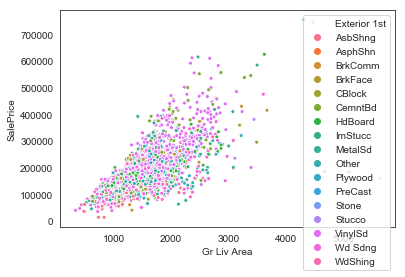

In [53]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Exterior 1st", s=15, data=df);

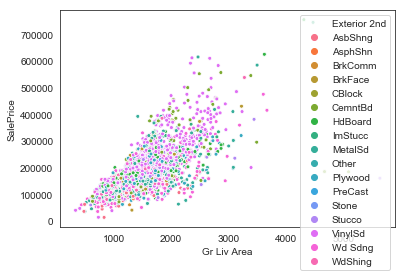

In [54]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Exterior 2nd", s=15, data=df);

In [55]:
del df["Exterior 1st"]
del df["Exterior 2nd"]

### Foundation

The type of foundation appears to have an effect. However, only three of the six realizations occur in a large number. Factor variables *found_BrkTil*, *found_CBlock*, and *found_PConc* are extracted but not regarded as "interesting".

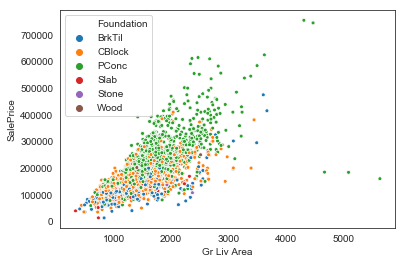

In [56]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Foundation", s=15, data=df);

In [57]:
df["Foundation"].value_counts()

PConc     1282
CBlock    1242
BrkTil     310
Slab        48
Stone       11
Wood         5
Name: Foundation, dtype: int64

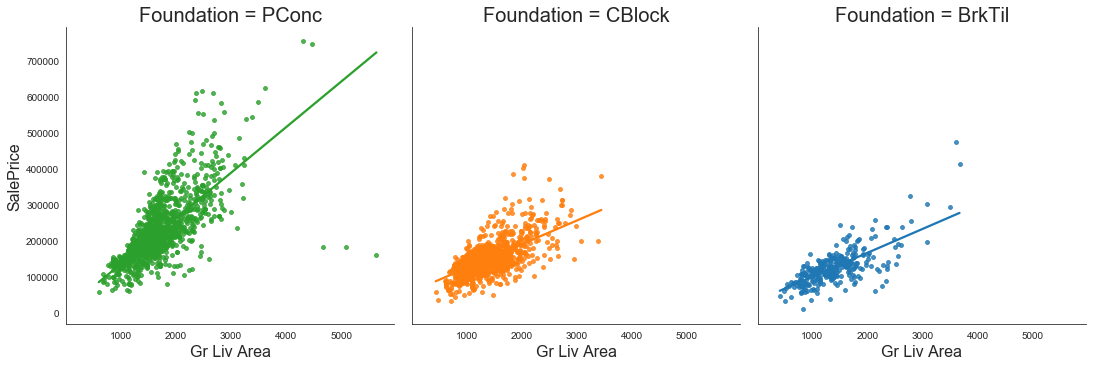

In [58]:
plot = sns.lmplot(
    x="Gr Liv Area", y="SalePrice", col="Foundation", hue="Foundation",
    col_order=["PConc", "CBlock", "BrkTil"],
    data=df, robust=True, col_wrap=4, ci=None, truncate=True, scatter_kws={"s": 15},
)
# Adjust font sizes.
for ax in plot.axes:
    ax.set_title(ax.get_title(), fontsize=20)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)

In [59]:
foundation = pd.get_dummies(df["Foundation"], prefix="found")
# Only keep the top 3 realizations.
del foundation["found_Slab"]
del foundation["found_Stone"]
del foundation["found_Wood"]
df = pd.concat([df, foundation], axis=1)
del df["Foundation"]

In [60]:
new_variables.extend(["found_BrkTil", "found_CBlock", "found_PConc"])

In [61]:
df[foundation.columns].head()

,,found_BrkTil,found_CBlock,found_PConc
Order,PID,,,
1,526301100,0,1,0
2,526350040,0,1,0
3,526351010,0,1,0
4,526353030,0,1,0
5,527105010,0,0,1


### Garage Type

As can be expected, the *Garage Type* looks very similar to the above *has Garage* variable. Therefore, it is dropped.

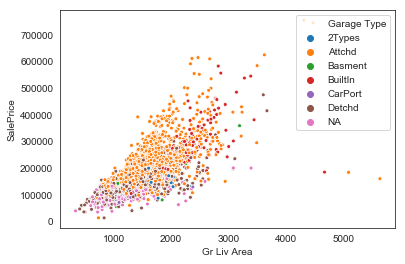

In [62]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Garage Type", s=15, data=df);

In [63]:
del df["Garage Type"]

### Heating

Most of the houses have gas. The variable is not helpful.

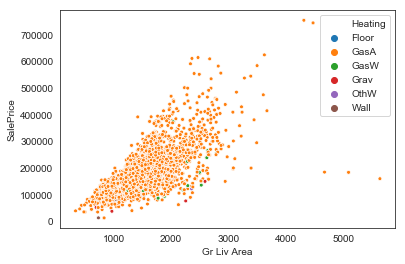

In [64]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Heating", s=15, data=df);

In [65]:
del df["Heating"]

### House Style

In summary, this variable is very similar to the above derived variable *has 2nd Flr*. Therefore, it is dropped.

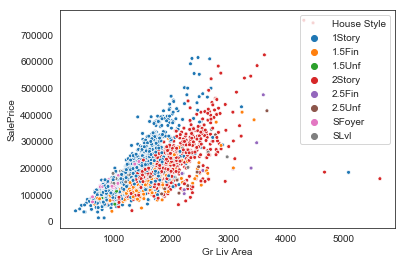

In [66]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="House Style", s=15, data=df);

In [67]:
del df["House Style"]

### Land Contour

This variable is assumed to contain the same information as the ordinal variable *Land Slope* and is dropped.

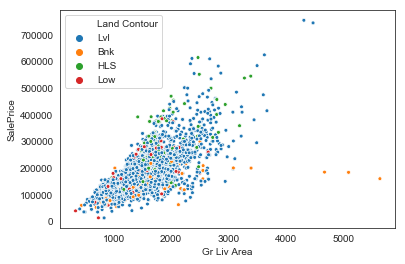

In [68]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Land Contour", s=15, data=df);

In [69]:
del df["Land Contour"]

### Lot Configuration

This variable shows no good pattern and is dropped.

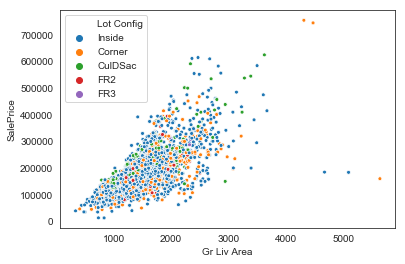

In [70]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Lot Config", s=15, data=df);

In [71]:
del df["Lot Config"]

### MS SubClass

By looking at this variable's realizations, one can see that several distinct features are lumped together in one. In particular, the above variables *has 2nd Flr* and *build_type_\** and the future age related features at the bottom of this notebook together should comprise the same patterns in a more advantagous way. Thus, the column is dropped.

In [72]:
list(ALL_COLUMNS["MS SubClass"]["lookups"].values())

['1-STORY 1946 & NEWER ALL STYLES',
 '1-STORY 1945 & OLDER',
 '1-STORY W/FINISHED ATTIC ALL AGES',
 '1-1/2 STORY - UNFINISHED ALL AGES',
 '1-1/2 STORY FINISHED ALL AGES',
 '2-STORY 1946 & NEWER',
 '2-STORY 1945 & OLDER',
 '2-1/2 STORY ALL AGES',
 'SPLIT OR MULTI-LEVEL',
 'SPLIT FOYER',
 'DUPLEX - ALL STYLES AND AGES',
 '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
 '1-1/2 STORY PUD - ALL AGES',
 '2-STORY PUD - 1946 & NEWER',
 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
 '2 FAMILY CONVERSION - ALL STYLES AND AGES']

In [73]:
del df["MS SubClass"]

### MS Zoning

This variable is dropped as most houses are located in a "residential" zone.

In [74]:
df["MS Zoning"].value_counts()

RL    2252
RM     459
FV     131
RH      27
C       25
I        2
A        2
RP       0
Name: MS Zoning, dtype: int64

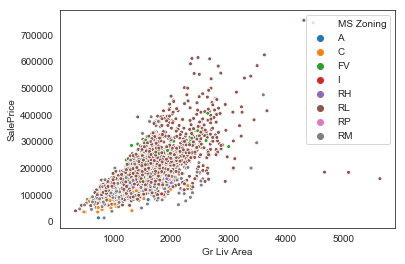

In [75]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="MS Zoning", s=15, data=df);

In [76]:
del df["MS Zoning"]

### Masonry Veneer Type

None of the groups have a slope differing from the overall one.

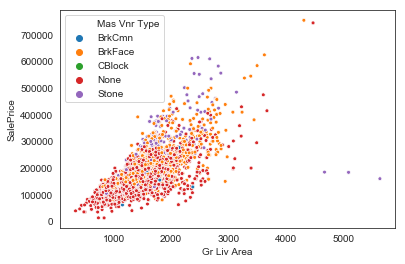

In [77]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Mas Vnr Type", s=15, data=df);

In [78]:
del df["Mas Vnr Type"]

### Miscellaneous Features

This variable is basically a "other" field with no pattern.

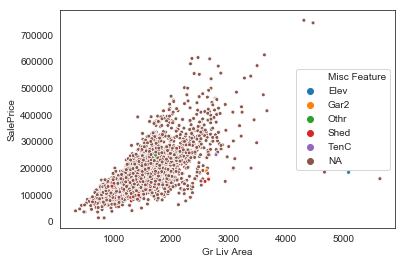

In [79]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Misc Feature", s=15, data=df);

In [80]:
del df["Misc Feature"]

### Roof

Roofs in Ames, IA, are not special enough to make a difference in the price. Even "hip" roofs seem already priced in bigger houses.

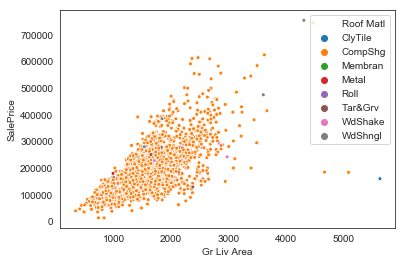

In [81]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Roof Matl", s=15, data=df);

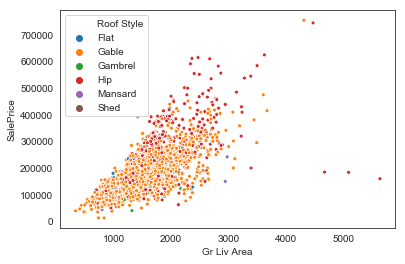

In [82]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Roof Style", s=15, data=df);

In [83]:
del df["Roof Matl"]
del df["Roof Style"]

### Sale Info

Partial and abnormal (= foreclosure) sales seem to make a change with higher and lower prices respectively. These two types will be encoded in factor variables *partial_sale* and *abnormal_sale*. The impact seems to be not big though.

In [84]:
df["Sale Condition"].value_counts()

Normal     2396
Partial     233
Abnorml     189
Family       46
Alloca       22
AdjLand      12
Name: Sale Condition, dtype: int64

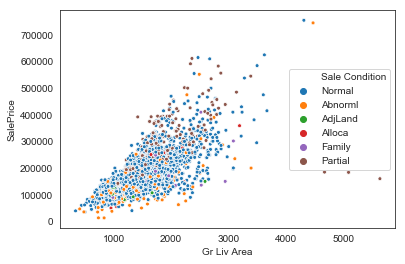

In [85]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Sale Condition", s=15, data=df);

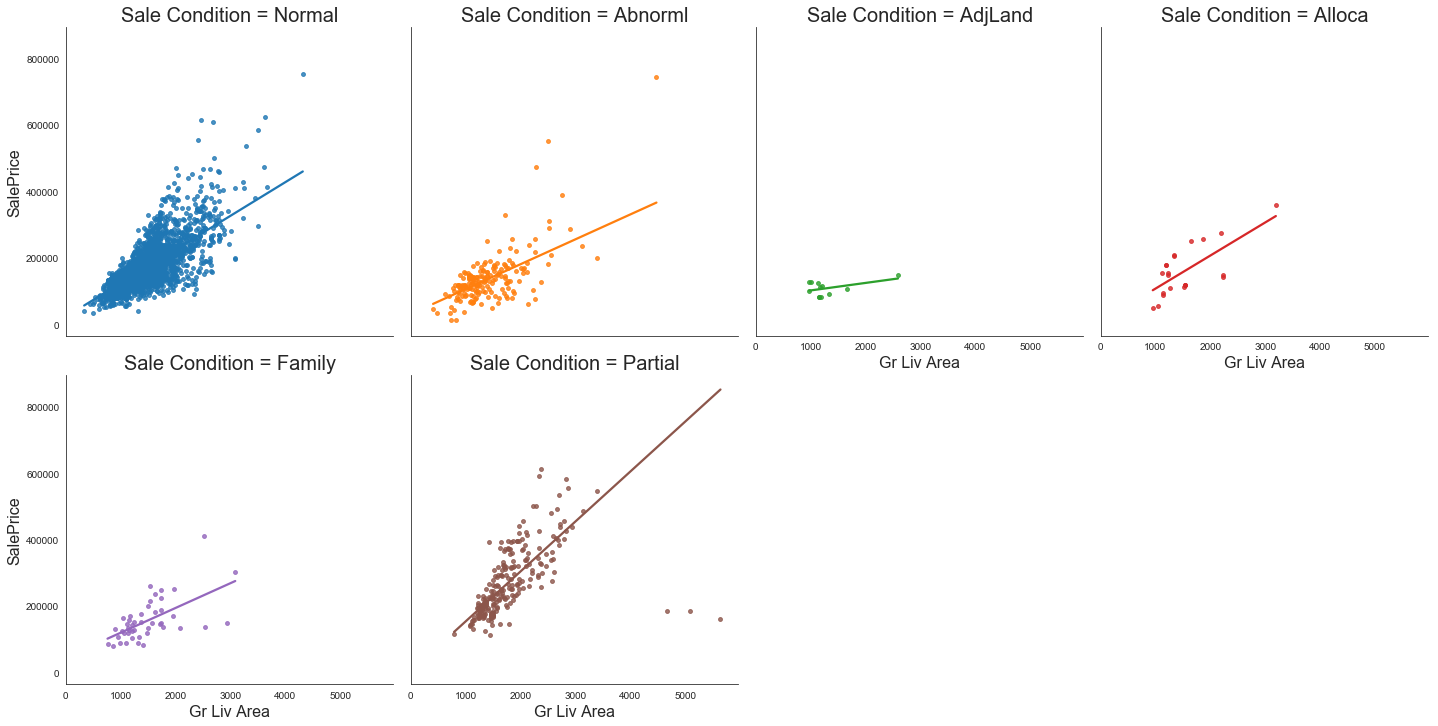

In [86]:
plot = sns.lmplot(
    x="Gr Liv Area", y="SalePrice", col="Sale Condition", hue="Sale Condition",
    data=df, robust=True, col_wrap=4, ci=None, truncate=True, scatter_kws={"s": 15},
)
# Adjust font sizes.
for ax in plot.axes:
    ax.set_title(ax.get_title(), fontsize=20)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)

In [87]:
df["partial_sale"] = df["Sale Condition"].apply(lambda x: 1 if x == "Partial" else 0)
df["abnormal_sale"] = df["Sale Condition"].apply(lambda x: 1 if x == "Abnorml" else 0)

Homes that are sold for the first time cleare are priced higher. A factor variable *new_home* is introduced.

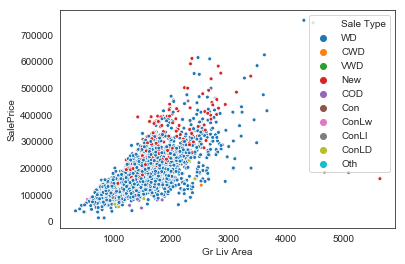

In [88]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="Sale Type", s=15, data=df);

In [89]:
df["new_home"] = df["Sale Type"].apply(lambda x: 1 if x == "New" else 0)

In [90]:
new_variables.extend(["partial_sale", "abnormal_sale", "new_home"])
interesting_variables.append("new_home")

In [91]:
del df["Sale Condition"]
del df["Sale Type"]

Show summary of counts:

In [92]:
df[["partial_sale", "abnormal_sale", "new_home"]].sum()

partial_sale     233
abnormal_sale    189
new_home         227
dtype: int64

In [93]:
df[["partial_sale", "abnormal_sale", "new_home"]].head()

,,partial_sale,abnormal_sale,new_home
Order,PID,,,
1,526301100,0,0,0
2,526350040,0,0,0
3,526351010,0,0,0
4,526353030,0,0,0
5,527105010,0,0,0


### Street Name

Looking at the value counts this variable is pretty useless.

In [94]:
df["Street"].value_counts()

Pave    2886
Grvl      12
Name: Street, dtype: int64

In [95]:
del df["Street"]

## Age & Remodeling

The dataset was put together over several years. Therefore, the variables with year numbers need to be aligned to indicate the right ages.

In [96]:
# For one house the year of being remodeled is one year
# before it was built. That input error is corrected.
input_error = (df["Year Remod/Add"] < df["Year Built"])
assert input_error.sum() == 1
df.loc[input_error, "Year Remod/Add"] = df.loc[input_error, "Year Built"]

Introduce a factor variable *remodeled*. Almost half the houses were remodeled at some point in time.

In [97]:
remodeled = (df["Year Remod/Add"] > df["Year Built"])
df["remodeled"] = 0
df.loc[remodeled, "remodeled"] = 1
round(100 * remodeled.sum() / df.shape[0])

46.0

Create discrete variables *years_since_built* and *years_since_remodeled*.

In [98]:
df["years_since_built"] = df["Yr Sold"] - df["Year Built"]
df["years_since_remodeled"] = df["Yr Sold"] - df["Year Remod/Add"]

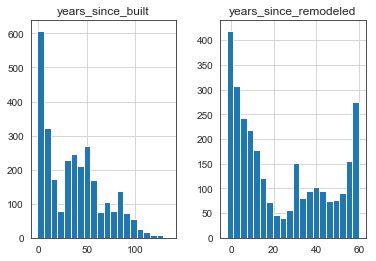

In [99]:
df[["years_since_built", "years_since_remodeled"]].hist(bins=20);

Two factor variables *recently_built* and *recently_remodeled* are created indicating that the corresponding action took place in the last 10 years. The two scatter plots below suggest that these groups of "recent vs. old" affect the price.

In [100]:
df["recently_built"] = df["years_since_built"].apply(lambda x: 1 if x <= 10 else 0)
df["recently_remodeled"] = df["years_since_remodeled"].apply(lambda x: 1 if x <= 10 else 0)

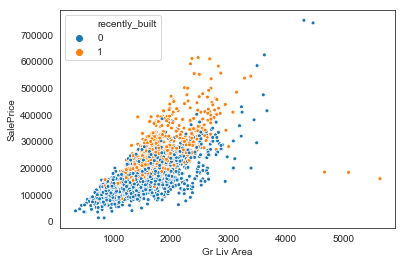

In [101]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="recently_built", s=15, data=df);

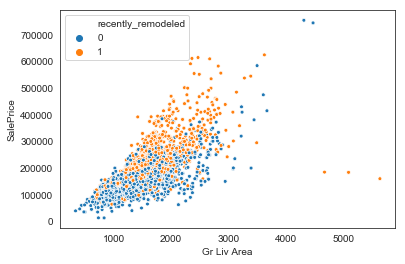

In [102]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="recently_remodeled", s=15, data=df);

In [103]:
del df["Yr Sold"]
del df["Year Built"]
del df["Year Remod/Add"]

In [104]:
age_columns = [
    "remodeled", "years_since_built", "years_since_remodeled",
    "recently_built", "recently_remodeled",
]
new_variables.extend(age_columns)
interesting_variables.extend(age_columns)

In [105]:
df[age_columns].head()

,,remodeled,years_since_built,years_since_remodeled,recently_built,recently_remodeled
Order,PID,,,,,
1,526301100,0,50,50,0,0
2,526350040,0,49,49,0,0
3,526351010,0,52,52,0,0
4,526353030,0,42,42,0,0
5,527105010,1,13,12,0,0


## Outliers

The instructors' notes state:

> **Five observations** that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
points). Three of them are true **outliers** (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced
relatively appropriately). I would **recommend removing any houses with more than
4000 square feet** from the data set (which eliminates these five unusual observations)
before assigning it to students.

To apply a more "rigorous" approach, outlier detection is conducted with a so-called Isolation Forest.

In [106]:
# Use only numeric columns that are strongly correlated with the target.
# This mitigates the risk that a "not so good" chosen factor variable introduced
# in this notebook causes an observation to be removed as an outlier.
with open("data/correlated_variables.json", "r") as file:
    content = json.loads(file.read())
strongly_correlated = content["strongly_correlated"]
df_encoded = encode_ordinals(df[list(set(strongly_correlated) & set(df.columns))])
# An Isolation Forest is a solid algorithm to find outliers.
iso = IsolationForest(
    n_estimators=1000, bootstrap=True, behaviour="new",
    contamination=0.005, random_state=random_state
)
outliers = pd.DataFrame(
    iso.fit_predict(df_encoded), columns=["outlier"], index=df.index
)
outliers["outlier"] = outliers["outlier"].apply(lambda x: 1 if x < 0 else 0)
df = pd.concat([df, outliers], axis=1)

The five aforementioned outliers are among the ones detected.

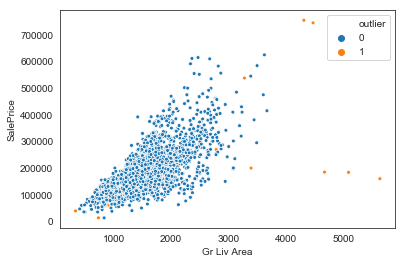

In [107]:
sns.scatterplot(x="Gr Liv Area", y="SalePrice", hue="outlier", s=15, data=df);

In [108]:
# Remove the outliers.
df = df[df["outlier"] == 0]

## Save the Results

### Save the "interesting" Variables

In [109]:
with open("data/interesting_variables.json", "w") as file:
    file.write(json.dumps(interesting_variables))

### Save the Data

In [110]:
# Re-order the columns for convenience.
final_columns = (
    sorted(set(list(ALL_COLUMNS.keys()) + new_variables) & set(df.columns))
    + TARGET_VARIABLES
)
df = df[final_columns]

Discarding useless and adding new predictors changed the final dataset significantly.

In [111]:
df.shape

(2883, 107)

In [112]:
df.head()

,,1st Flr SF,2nd Flr SF,3Ssn Porch,Bedroom AbvGr,Bsmt Cond,Bsmt Exposure,Bsmt Full Bath,Bsmt Half Bath,Bsmt Qual,Bsmt Unf SF,BsmtFin SF 1,BsmtFin SF 2,BsmtFin Type 1,BsmtFin Type 2,Electrical,Enclosed Porch,Exter Cond,Exter Qual,Fence,Fireplace Qu,Fireplaces,Full Bath,Functional,Garage Area,Garage Cars,Garage Cond,Garage Finish,Garage Qual,Gr Liv Area,Half Bath,Heating QC,Kitchen AbvGr,Kitchen Qual,Land Slope,Lot Area,Lot Shape,Low Qual Fin SF,Mas Vnr Area,Misc Val,Mo Sold,Open Porch SF,Overall Cond,Overall Qual,Paved Drive,Pool Area,Pool QC,Screen Porch,TotRms AbvGrd,Total Bath,Total Bsmt SF,Total Porch SF,Utilities,Wood Deck SF,abnormal_sale,air_cond,build_type_1Fam,build_type_2Fam,build_type_Twnhs,found_BrkTil,found_CBlock,found_PConc,has 2nd Flr,has Bsmt,has Fireplace,has Garage,has Pool,has Porch,major_street,new_home,nhood_Blmngtn,nhood_Blueste,nhood_BrDale,nhood_BrkSide,nhood_ClearCr,nhood_CollgCr,nhood_Crawfor,nhood_Edwards,nhood_Gilbert,nhood_Greens,nhood_GrnHill,nhood_IDOTRR,nhood_Landmrk,nhood_MeadowV,nhood_Mitchel,nhood_NPkVill,nhood_NWAmes,nhood_Names,nhood_NoRidge,nhood_NridgHt,nhood_OldTown,nhood_SWISU,nhood_Sawyer,nhood_SawyerW,nhood_Somerst,nhood_StoneBr,nhood_Timber,nhood_Veenker,park,partial_sale,railway,recently_built,recently_remodeled,remodeled,years_since_built,years_since_remodeled,SalePrice,SalePrice (box-cox-0.0)
Order,PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,526301100,1656.0,0.0,0.0,3,Gd,Gd,1,0,TA,441.0,639.0,0.0,BLQ,Unf,SBrkr,0.0,TA,TA,NA,Gd,2,1,Typ,528.0,2,TA,Fin,TA,1656.0,0,Fa,1,TA,Gtl,31770.0,IR1,0.0,112.0,0.0,5,62.0,5,6,P,0.0,NA,0.0,7,2.0,1080.0,272.0,AllPub,210.0,0,1,1,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,50,215000.0,12.278393
2,526350040,896.0,0.0,0.0,2,TA,No,0,0,TA,270.0,468.0,144.0,Rec,LwQ,SBrkr,0.0,TA,TA,MnPrv,NA,0,1,Typ,730.0,1,TA,Unf,TA,896.0,0,TA,1,TA,Gtl,11622.0,Reg,0.0,0.0,0.0,6,0.0,6,5,Y,0.0,NA,120.0,5,1.0,882.0,260.0,AllPub,140.0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,49,105000.0,11.561716
3,526351010,1329.0,0.0,0.0,3,TA,No,0,0,TA,406.0,923.0,0.0,ALQ,Unf,SBrkr,0.0,TA,TA,NA,NA,0,1,Typ,312.0,1,TA,Unf,TA,1329.0,1,TA,1,Gd,Gtl,14267.0,IR1,0.0,108.0,12500.0,6,36.0,6,6,Y,0.0,NA,0.0,6,1.5,1329.0,429.0,AllPub,393.0,0,1,1,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52,52,172000.0,12.055250
4,526353030,2110.0,0.0,0.0,3,TA,No,1,0,TA,1045.0,1065.0,0.0,ALQ,Unf,SBrkr,0.0,TA,Gd,NA,TA,2,2,Typ,522.0,2,TA,Fin,TA,2110.0,1,Ex,1,Ex,Gtl,11160.0,Reg,0.0,0.0,0.0,4,0.0,5,7,Y,0.0,NA,0.0,8,3.5,2110.0,0.0,AllPub,0.0,0,1,1,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,42,244000.0,12.404924
5,527105010,928.0,701.0,0.0,3,TA,No,0,0,Gd,137.0,791.0,0.0,GLQ,Unf,SBrkr,0.0,TA,TA,MnPrv,TA,1,2,Typ,482.0,2,TA,Fin,TA,1629.0,1,Gd,1,TA,Gtl,13830.0,IR1,0.0,0.0,0.0,3,34.0,5,5,Y,0.0,NA,0.0,6,2.5,928.0,246.0,AllPub,212.0,0,1,1,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,13,12,189900.0,12.154253


In [113]:
df.to_csv("data/data_clean_with_transformations_and_factors.csv")